In [1]:
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, PyPlot, ChaosTools, DynamicalSystems, Distributions, BenchmarkTools, StaticArrays, RandomNumbers, DSP, StatsBase, NPZ, TimerOutputs, Printf

┌ Info: Precompiling ChaosTools [608a59af-f2a3-5ad4-90b4-758bdf3122a7]
└ @ Base loading.jl:1273
┌ Info: Precompiling DynamicalSystems [61744808-ddfa-5f27-97ff-6e42cc95d634]
└ @ Base loading.jl:1273
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273


In [2]:
using Pkg
Pkg.add("StaticArrays")
Pkg.add("BenchmarkTools")
Pkg.add("DSP")
Pkg.add("StatsBase")
Pkg.add("NPZ")
Pkg.add("TimerOutputs")
Pkg.add("Printf")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %=========>                               ]  21.0 %>                     ]  46.4 %===========================>             ]  67.4 %.8 % Resolving package versions...
 Installed OpenBLAS_jll ──────── v0.3.9+1
 Installed Arpack_jll ────────── v3.5.0+3
 Installed FillArrays ────────── v0.8.7
 Installed DiffEqBase ────────── v6.25.2
 Installed RecursiveArrayTools ─ v2.1.2
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [68821587] ↑ Arpack_jll v3.5.0+2 ⇒ v3.5.0+3
  [2b5f629d] ↑ DiffEqBase v6.25.1 ⇒ v6.25.2
  [1a297f60] ↑ FillArrays v0.8.6 ⇒ v0.8.7
  [4536629a] ↑ OpenBLAS_jll v0.3.9+0 ⇒ v0.3.9+1
  [731186ca] ↑ RecursiveArrayTools v2.1.0 ⇒ v2.1.2
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no 

# Calculo para las energías de los osciladores y su frecuencia

In [164]:
Hosci!(x,p,w)=p*p/(2. *0.1)+0.5*0.1*w^2. *x^2.
println(Hosci(6,0.3))
freq(x,p,E)=sqrt((E-p*p/(2. *0.1))/(0.5*0.1*x*x*0.6324555320336759^2.))
println(freq(6.,0.3,Hosci(5,0.25)))
Hsys!(x,p)=p*p/(2.)-a*x*x/2. +b*x*x*x*x/4. +1.
Htotal!(x,p,X,P,w)=p*p/(2.)-a*x*x/2. +b*x*x*x*x/4. +1. +P*P/(2. *0.1)+0.5*0.1*w^2. *X^2. -g[2]*x*X +x*x*g[2]*g[2]/(2. *0.1*w*w)

1.0332
0.6095307849303248


Htotal! (generic function with 1 method)

# Un oscilador

 38.754829 seconds (6.00 M allocations: 243.018 MiB)


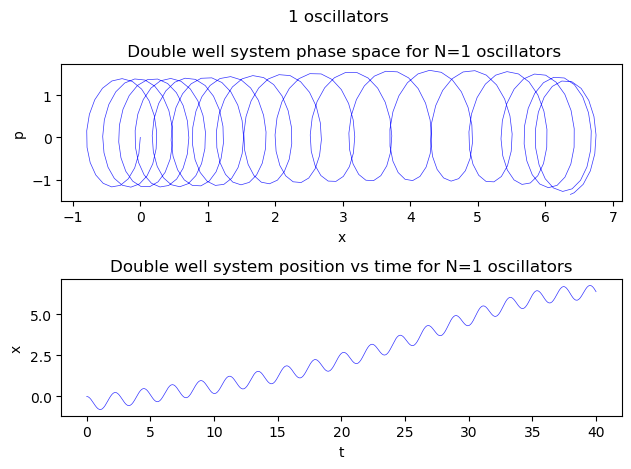

[0.6257304315846814, 1.0]


In [166]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

function initial_sampling(Eb,w1,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 5))
end

a=0.2
b=0.01

m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]

X0=17.    
P0=1.
time=40.
tspan=(0., time)
m[2]=0.1
w[2]=0.6324555320336759*0.9
g[2]=0.5

W=maximum(w)
Es=zeros(1+1)
Es=(bolz_energy.(Es))
Es=Es./sum(Es[2:end])

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.)+1.
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)


for i in 2:1+1
    i=Int(i)
    initial_position[i], initial_momentum[i]=initial_sampling(Es[i],w[i],m[i])
end


initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, SofSpa10(), dt=dts, abstol=1e-14, reltol=1e-14);
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)
title("1 oscillators \n \n Double well system phase space for N=1 oscillators")
xlabel("x")
ylabel("p")
plot(sol4[3,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
title("Double well system position vs time for N=1 oscillators")
xlabel("t")
ylabel("x")
plot(sol4.t[:],sol4[3,:],color="b",linewidth=0.5,alpha=0.8)
fig.tight_layout()
println(Es)


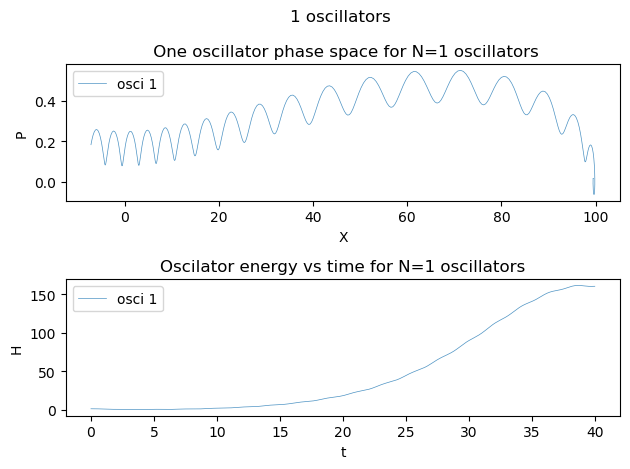

[0.0, -7.16911763787346]
[0.0, 0.1829649076561803]


In [167]:
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)

title("1 oscillators \n \n One oscillator phase space for N=1 oscillators")
xlabel("X")
ylabel("P")
plot(sol4[1+2+1,:],sol4[1+1,:],linewidth=0.5,alpha=0.8,label="osci 1")

legend()
subplot(2, 1, 2)

title("Oscilator energy vs time for N=1 oscillators")
xlabel("t")
ylabel("H")
plot(sol4.t[:], Hosci!.(sol4[1+2+1,:],sol4[1+1,:],w[2]),linewidth=0.5,alpha=0.8,label="osci 1")
legend()
fig.tight_layout()
println(initial_position)
println(initial_momentum)


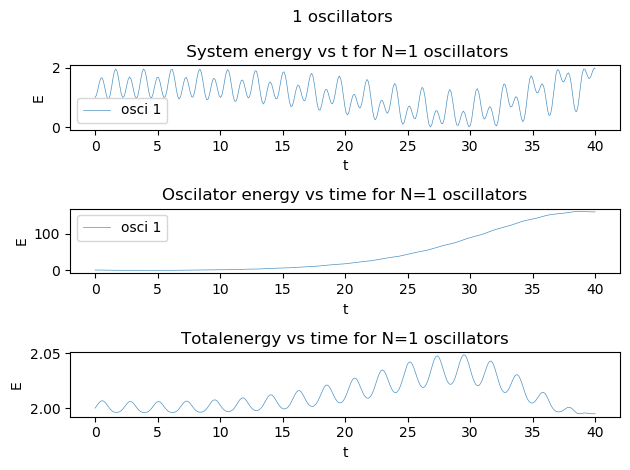

In [168]:
fig, axes = subplots(nrows=3, ncols=1)
subplot(3, 1, 1)

title("1 oscillators \n \n System energy vs t for N=1 oscillators")
xlabel("t")
ylabel("E")
plot(sol4.t[:],Hsys!.(sol4[2+1,:],sol4[1,:]),linewidth=0.5,alpha=0.8,label="osci 1")

legend()
subplot(3, 1, 2)

title("Oscilator energy vs time for N=1 oscillators")
xlabel("t")
ylabel("E")
plot(sol4.t[:], Hosci!.(sol4[1+2+1,:],sol4[1+1,:],w[2]),linewidth=0.5,alpha=0.8,label="osci 1")
legend()

subplot(3, 1, 3)

title("Totalenergy vs time for N=1 oscillators")
xlabel("t")
ylabel("E")
plot(sol4.t[:], Htotal!.(sol4[2+1,:],sol4[1,:],sol4[1+2+1,:],sol4[1+1,:],w[2]),linewidth=0.5,alpha=0.8,label="osci 1")

fig.tight_layout()

# Tres osciladores

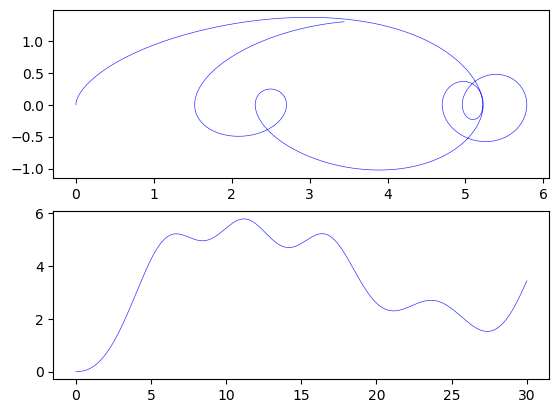

  2.386360 seconds (5.89 M allocations: 227.095 MiB)
[1.3754382301070447, 0.14548223350163236, 0.026635399769841188, 0.8278823667285264]


In [129]:
initial_position = [0.1, 0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.]

function initial_sampling(Eb,w1,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 5))
end

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.9]

X0=17.    
P0=1.
W=0.6324555320336759
time=30.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759*0.9
g[2]=0.07
w[3]=0.6324555320336759*1.2639842760097928
g[3]=0.07
w[4]=0.6324555320336759*0.6925256939166184
g[4]=0.07

Es=zeros(3+1)
Es=(bolz_energy.(Es))
Es=Es./sum(Es[2:end])

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=5.#Xz0[jj]
initial_momentum[2]=0.25#Pz1[jj]
initial_position[3]=4.#Xz0[jj]
initial_momentum[3]=0.2#Pz1[jj]
initial_position[4]=7.#Xz0[jj]
initial_momentum[4]=0.35#Pz1[jj]

for i in 2:3+1
    i=Int(i)
    initial_position[i], initial_momentum[i]=initial_sampling(Es[i],w[i],m[i])
end


initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[5,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4.t[:],sol4[5,:],color="b",linewidth=0.5,alpha=0.8)
println(Es)

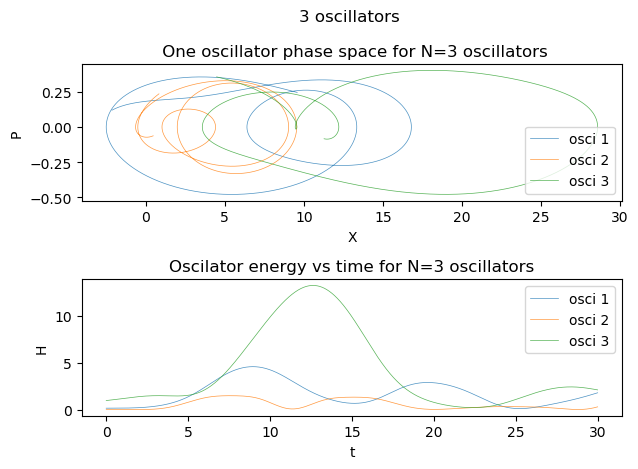

In [130]:
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)

title("3 oscillators \n \n One oscillator phase space for N=3 oscillators")
xlabel("X")
ylabel("P")
plot(sol4[3+2+1,:],sol4[1+1,:],linewidth=0.5,alpha=0.8,label="osci 1")
plot(sol4[3+2+2,:],sol4[1+2,:],linewidth=0.5,alpha=0.8,label="osci 2")
plot(sol4[3+2+3,:],sol4[1+3,:],linewidth=0.5,alpha=0.8,label="osci 3")
legend()
subplot(2, 1, 2)

title("Oscilator energy vs time for N=3 oscillators")
xlabel("t")
ylabel("H")
plot(sol4.t[:], Hosci!.(sol4[3+2+1,:],sol4[1+1,:]),linewidth=0.5,alpha=0.8,label="osci 1")
plot(sol4.t[:], Hosci!.(sol4[3+2+2,:],sol4[1+2,:]),linewidth=0.5,alpha=0.8,label="osci 2")
plot(sol4.t[:], Hosci!.(sol4[3+2+3,:],sol4[1+3,:]),linewidth=0.5,alpha=0.8,label="osci 3")
legend()
fig.tight_layout()

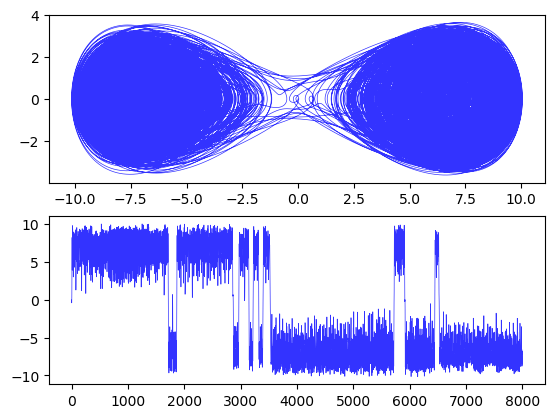

 53.540913 seconds (555.60 M allocations: 18.499 GiB, 18.71% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x168fac2d0>

In [131]:
initial_position = [0.1, 0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=8000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759
g[2]=0.03
w[3]=0.6324555320336759/2.
g[3]=0.05
w[4]=0.6324555320336759*2.
g[4]=0.07

dts=0.001*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) 
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2.  +q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=5.35#Xz0[jj]
initial_momentum[2]=0.27#Pz1[jj]
initial_position[3]=0.#Xz0[jj]
initial_momentum[3]=-0.27#Pz1[jj]
initial_position[4]=0.#Xz0[jj]
initial_momentum[4]=0.#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol1 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol1[5,:],sol1[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol1.t[:],sol1[5,:],color="b",linewidth=0.5,alpha=0.8)

# Cuatro osciladores

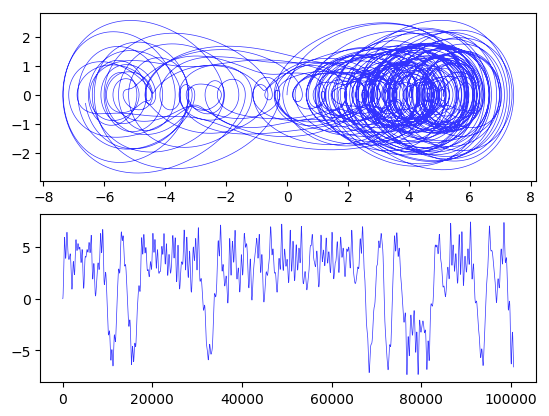

  8.217179 seconds (120.19 M allocations: 4.052 GiB, 17.57% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e1d09e940>

In [23]:
initial_position = [0.1, 0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=1000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759
g[2]=0.07
w[3]=0.6324555320336759*1.2639842760097928
g[3]=0.07
w[4]=0.6324555320336759*0.6925256939166184
g[4]=0.07
w[5]=0.6324555320336759*1.9720265943665387
g[5]=0.07

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=5.#Xz0[jj]
initial_momentum[2]=0.25#Pz1[jj]
initial_position[3]=4.#Xz0[jj]
initial_momentum[3]=0.2#Pz1[jj]
initial_position[4]=7.#Xz0[jj]
initial_momentum[4]=0.35#Pz1[jj]
initial_position[5]=3.#Xz0[jj]
initial_momentum[5]=0.15#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[6,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4[6,:],color="b",linewidth=0.5,alpha=0.8)

# Cinco osciladores

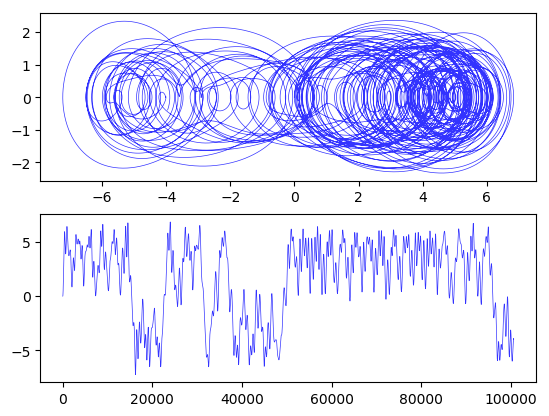

  9.614620 seconds (145.60 M allocations: 4.936 GiB, 13.86% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8e1cbc36a0>

In [26]:
initial_position = [0.1, 0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=1000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759
g[2]=0.07
w[3]=0.6324555320336759*1.2639842760097928
g[3]=0.07
w[4]=0.6324555320336759*0.6925256939166184
g[4]=0.07
w[5]=0.6324555320336759*1.9720265943665387
g[5]=0.07
w[6]=0.6324555320336759*3.087272258807117
g[6]=0.07

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=5.#Xz0[jj]
initial_momentum[2]=0.25#Pz1[jj]
initial_position[3]=4.#Xz0[jj]
initial_momentum[3]=0.2#Pz1[jj]
initial_position[4]=7.#Xz0[jj]
initial_momentum[4]=0.35#Pz1[jj]
initial_position[5]=3.#Xz0[jj]
initial_momentum[5]=0.15#Pz1[jj]
initial_position[6]=2.#Xz0[jj]
initial_momentum[6]=0.1#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[7,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4[7,:],color="b",linewidth=0.5,alpha=0.8)

# Seis osciladores

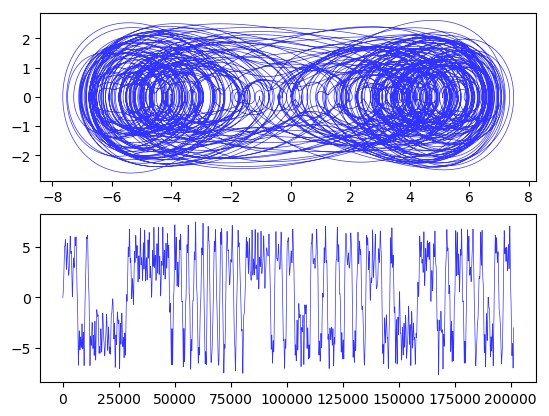

 19.682686 seconds (338.81 M allocations: 13.143 GiB, 16.92% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb8918cf048>

In [13]:
initial_position = [0.1, 0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=2000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759*0.6925256939166184
g[2]=0.04
w[3]=0.6324555320336759
g[3]=0.07
w[4]=0.6324555320336759
g[4]=0.04
w[5]=0.6324555320336759*1.2639842760097928
g[5]=0.07
w[6]=0.6324555320336759*1.9720265943665387
g[6]=0.04
w[7]=0.6324555320336759*3.087272258807117
g[7]=0.07

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=7.#Xz0[jj]
initial_momentum[2]=0.35#Pz1[jj]
initial_position[3]=5.#Xz0[jj]
initial_momentum[3]=-0.25#Pz1[jj]
initial_position[4]=-5.#Xz0[jj]
initial_momentum[4]=-0.25#Pz1[jj]
initial_position[5]=-4.#Xz0[jj]
initial_momentum[5]=0.20#Pz1[jj]
initial_position[6]=3.#Xz0[jj]
initial_momentum[6]=0.15#Pz1[jj]
initial_position[7]=2.#Xz0[jj]
initial_momentum[7]=-0.1#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[8,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4[8,:],color="b",linewidth=0.5,alpha=0.8)

# Siete osciladores

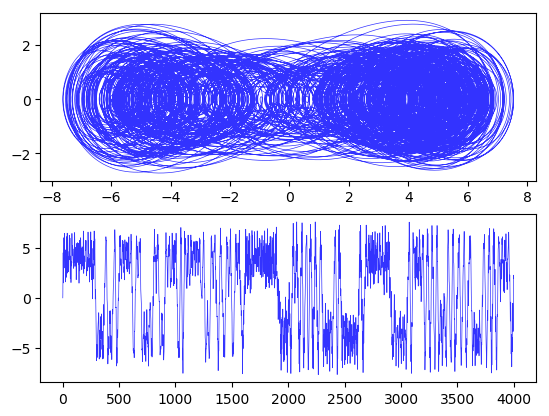

 58.573620 seconds (775.92 M allocations: 30.234 GiB, 17.07% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb8900626d8>

In [30]:
initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=4000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759*0.6925256939166184
g[2]=0.04
w[3]=0.6324555320336759
g[3]=0.07
w[4]=0.6324555320336759
g[4]=0.04
w[5]=0.6324555320336759*1.2639842760097928
g[5]=0.07
w[6]=0.6324555320336759*1.9720265943665387
g[6]=0.04
w[7]=0.6324555320336759*3.087272258807117
g[7]=0.07
w[8]=0.6324555320336759*0.7095577652469335
g[8]=0.07

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=7.#Xz0[jj]
initial_momentum[2]=0.35#Pz1[jj]
initial_position[3]=5.#Xz0[jj]
initial_momentum[3]=0.25#Pz1[jj]
initial_position[4]=5.#Xz0[jj]
initial_momentum[4]=-0.25#Pz1[jj]
initial_position[5]=4.#Xz0[jj]
initial_momentum[5]=0.20#Pz1[jj]
initial_position[6]=3.#Xz0[jj]
initial_momentum[6]=0.15#Pz1[jj]
initial_position[7]=2.#Xz0[jj]
initial_momentum[7]=0.1#Pz1[jj]
initial_position[8]=6.#Xz0[jj]
initial_momentum[8]=-0.3#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[9,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4.t[:], sol4[9,:], color="b",linewidth=0.5,alpha=0.8)

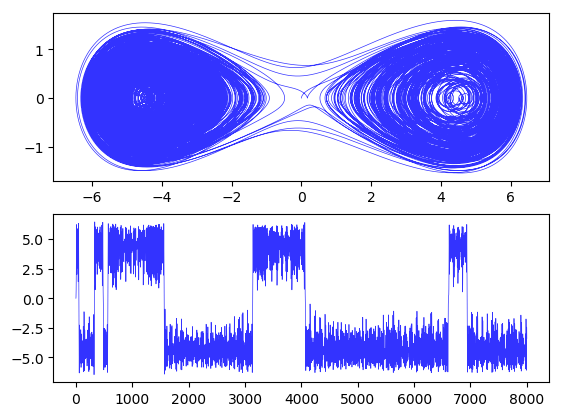

103.345167 seconds (1.55 G allocations: 60.319 GiB, 16.54% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb7e9456588>

In [40]:
initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.
W=0.6324555320336759
time=8000.
tspan=(0., time)
#fig=figure()
m[2]=0.1
m[3]=0.1
m[4]=0.1
w[2]=0.6324555320336759*0.6925256939166184
g[2]=0.01
w[3]=0.6324555320336759
g[3]=0.01
w[4]=0.6324555320336759
g[4]=0.01
w[5]=0.6324555320336759*1.2639842760097928
g[5]=0.01
w[6]=0.6324555320336759*1.9720265943665387
g[6]=0.01
w[7]=0.6324555320336759*3.087272258807117
g[7]=0.01
w[8]=0.6324555320336759*0.7095577652469335
g[8]=0.01

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=0.#Xz0[jj]
initial_momentum[2]=0.#Pz1[jj]
initial_position[3]=5.#Xz0[jj]
initial_momentum[3]=0.25#Pz1[jj]
initial_position[4]=0.#Xz0[jj]
initial_momentum[4]=0.#Pz1[jj]
initial_position[5]=0.#Xz0[jj]
initial_momentum[5]=0.#Pz1[jj]
initial_position[6]=0.#Xz0[jj]
initial_momentum[6]=0.#Pz1[jj]
initial_position[7]=0.#Xz0[jj]
initial_momentum[7]=0.#Pz1[jj]
initial_position[8]=0.#Xz0[jj]
initial_momentum[8]=-0.#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol4 = solve(prob, CalvoSanz4(), dt=dts);
subplot(2, 1, 1)
plot(sol4[9,:],sol4[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol4.t[:], sol4[9,:], color="b",linewidth=0.5,alpha=0.8)

In [3]:
subplot(2, 2, 1)
title("7 oscillators")
plot(sol4[9,:],sol4[1,:],color="b",linewidth=0.2,alpha=0.8)
subplot(2, 2, 3)
plot(sol4.t[:], sol4[9,:], color="b",linewidth=0.2,alpha=0.8)
subplot(2, 2, 2)
title("3 oscillators")
plot(sol1[5,:],sol1[1,:],color="b",linewidth=0.2,alpha=0.8)
subplot(2, 2, 4)
plot(sol1.t[:], sol1[5,:], color="b",linewidth=0.2,alpha=0.8)

UndefVarError: UndefVarError: sol4 not defined

# Ocho osciladores

In [17]:
function initial_sampling(E,w,m,M)
    nums=rand(1)*2*pi
    x=cos(nums[1])*sqrt(E/(0.5*M*w*w))
    y=sin(nums[1])*sqrt(2*m*E)
    return x,y
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0.1, 3))

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

time=100.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.2001
g[2]=0.02
w[3]=0.6324555320336759-0.2
g[3]=0.01
w[4]=0.6324555320336759-0.1001
g[4]=0.04
w[5]=0.6324555320336759-0.1
g[5]=0.01
w[6]=0.6324555320336759+0.2001
g[6]=0.06
w[7]=0.6324555320336759+0.2
g[7]=0.07
w[8]=0.6324555320336759+0.1001
g[8]=0.04
w[9]=0.6324555320336759+0.1
g[9]=0.02

W=maximum(w)

dts=0.001*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2]=1.#Xz0[jj]
initial_momentum[2]=0.05#Pz1[jj]
initial_position[3]=-1.#Xz0[jj]
initial_momentum[3]=-0.05#Pz1[jj]
initial_position[4]=-1.5#Xz0[jj]
initial_momentum[4]=0.075#Pz1[jj]
initial_position[5]=1.5#Xz0[jj]
initial_momentum[5]=-0.075#Pz1[jj]
initial_position[6]=0.5#Xz0[jj]
initial_momentum[6]=0.025#Pz1[jj]
initial_position[7]=-0.5#Xz0[jj]
initial_momentum[7]=-0.025#Pz1[jj]
initial_position[8]=-2.#Xz0[jj]
initial_momentum[8]=0.1#Pz1[jj]
initial_position[9]=2.#Xz0[jj]
initial_momentum[9]=-0.1#Pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol8 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol8[10,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol8.t[:], sol8[10,:], color="b",linewidth=0.5,alpha=0.8)

LoadError: syntax: incomplete: "function" at none:2 requires end

[0.0, 0.48235553203367587, 0.48245553203367586, 0.5323555320336759, 0.5324555320336759, 0.8325555320336759, 0.832455532033676, 0.7325555320336758, 0.7324555320336759]
 

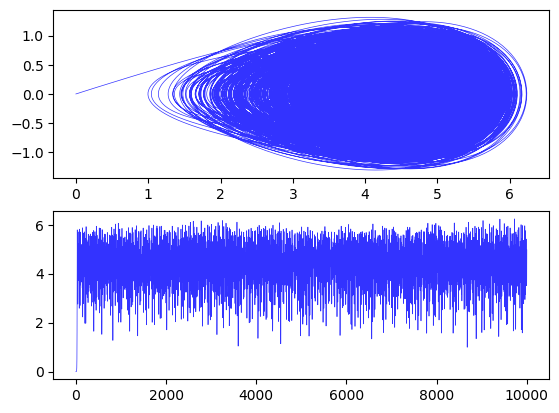

35.649408 seconds (291.22 M allocations: 12.796 GiB, 13.85% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1c6f445d0>

In [19]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(9)

X0=17.    
P0=1.

time=10000.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04

g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001
println(w)

W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol8 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol8[10,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol8.t[:], sol8[10,:], color="b",linewidth=0.5,alpha=0.8)

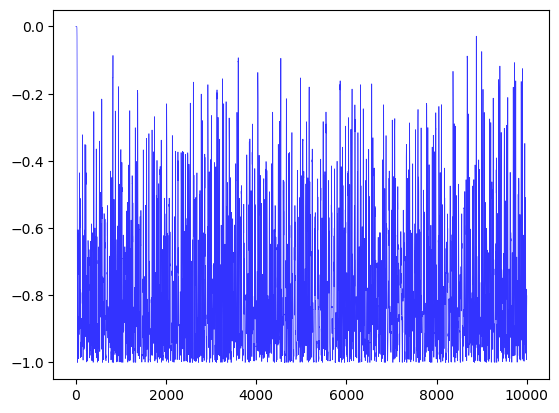

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1fdd55d10>

In [25]:
E8=Hsys!.(sol8[10,:],sol8[1,:])
plot(sol8.t[:], E8, color="b",linewidth=0.5,alpha=0.8)

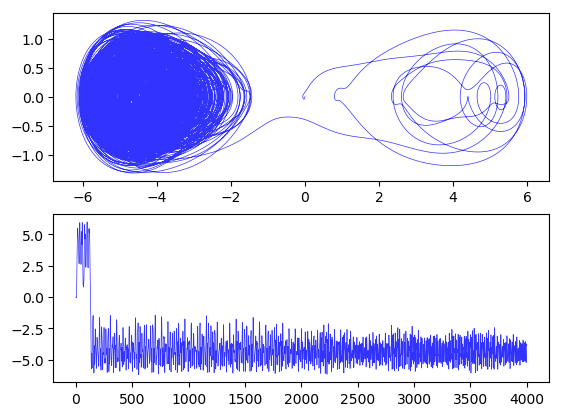

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f648a09e860>

In [19]:
subplot(2, 1, 1)
plot(sol8[10,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol8.t[:], sol8[10,:], color="b",linewidth=0.5,alpha=0.8)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


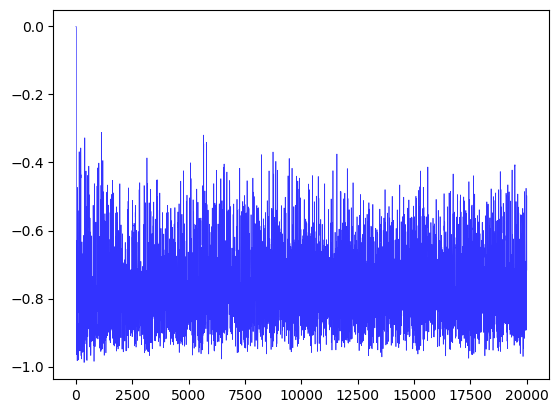

50


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15088ffd0>

In [41]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(9)

X0=17.    
P0=1.

EE8=0.
sol8=0.

for i in 1:50
println(i)

time=20000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04




g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol8 = solve(prob, CalvoSanz4(), dt=dts)
if i==1
    EE8=Hsys!.(sol8[10,:],sol8[1,:])
    else
        EE8=(EE8+Hsys!.(sol8[10,:],sol8[1,:])) ./2.
    end
end
plot(sol8.t[:], EE8, color="b",linewidth=0.5,alpha=0.8)

# Diez Osciladores

[0.0, 0.48235553203367587, 0.48245553203367586, 0.5323555320336759, 0.5324555320336759, 0.8325555320336759, 0.832455532033676, 0.7325555320336758, 0.7324555320336759, 0.7625555320336759, 0.7624555320336759]
 

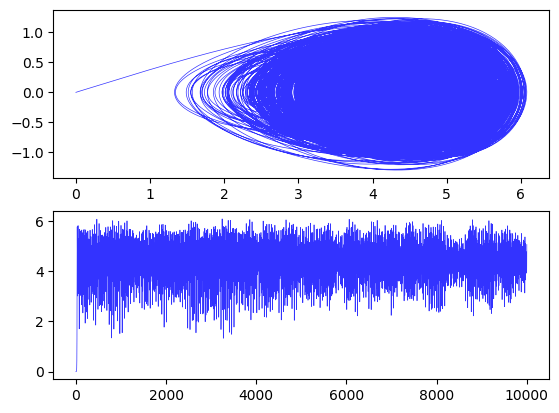

51.446946 seconds (357.92 M allocations: 17.684 GiB, 15.67% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1f4400310>

In [20]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(11)

X0=17.    
P0=1.

time=10000.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023

g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001
println(w)

W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol10 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol10[12,:],sol10[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol10.t[:], sol10[12,:], color="b",linewidth=0.5,alpha=0.8)

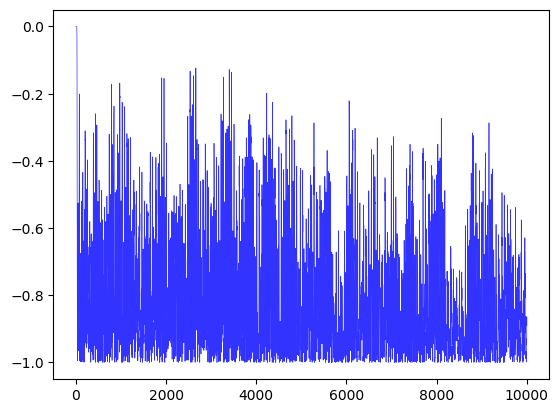

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x17569f390>

In [26]:
E10=Hsys!.(sol10[12,:],sol10[1,:])
plot(sol10.t[:], E10, color="b",linewidth=0.5,alpha=0.8)

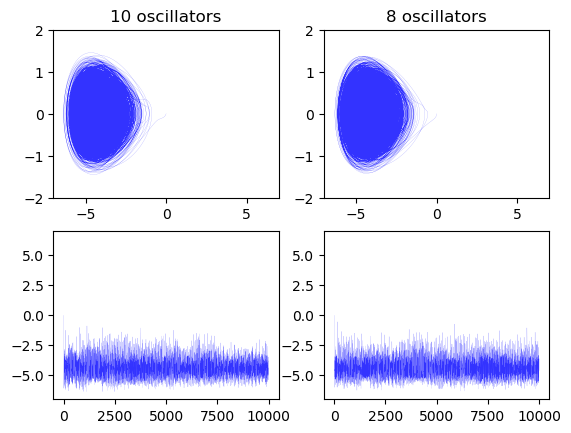

(-7, 7)

In [57]:
subplot(2, 2, 1)
title("10 oscillators")
plot(sol10[12,:],sol10[1,:],color="b",linewidth=0.08,alpha=0.8)
xlim([-7,7])
ylim([-2,2])
subplot(2, 2, 3)
plot(sol10.t[:], sol10[12,:], color="b",linewidth=0.08,alpha=0.8)
ylim([-7,7])
subplot(2, 2, 2)
title("8 oscillators")
plot(sol8[10,:],sol8[1,:],color="b",linewidth=0.08,alpha=0.8)
xlim([-7,7])
ylim([-2,2])
subplot(2, 2, 4)
plot(sol8.t[:], sol8[10,:], color="b",linewidth=0.08,alpha=0.8)
ylim([-7,7])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


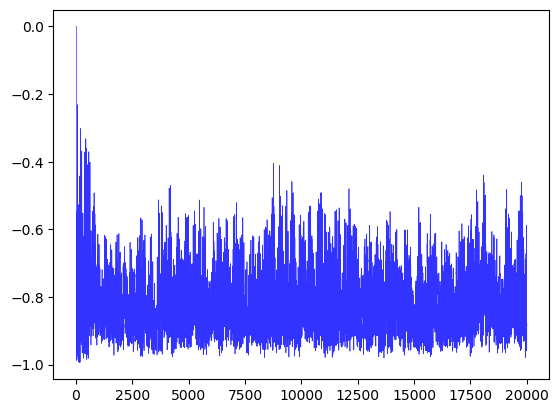

50


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x203996d90>

In [42]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(11)

X0=17.    
P0=1.

EE10=0.
sol10=0.

for i in 1:50
println(i)

time=20000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023



g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol10 = solve(prob, CalvoSanz4(), dt=dts)

if i==1
    EE10=Hsys!.(sol10[12,:],sol10[1,:])
    else
        EE10=(EE10+Hsys!.(sol10[12,:],sol10[1,:])) ./2.
    end
end
plot(sol10.t[:], EE10, color="b",linewidth=0.5,alpha=0.8)

# Doce osciladores

[0.0, 0.48235553203367587, 0.48245553203367586, 0.5323555320336759, 0.5324555320336759, 0.8325555320336759, 0.832455532033676, 0.7325555320336758, 0.7324555320336759, 0.7625555320336759, 0.7624555320336759, 0.8025555320336759, 0.8024555320336759]
 95.650142 seconds (840.43 M allocations: 29.731 GiB, 18.32% gc time)


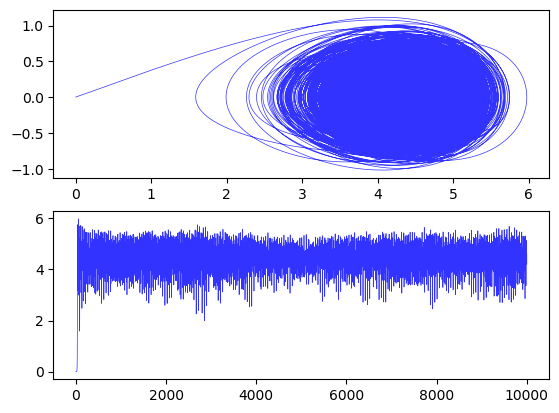

-1.53336897996700140.36323889469710696
1.5335600645715377-0.36323889469710696


In [21]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(13)

X0=17.    
P0=1.

time=10000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023
w[12]=0.6324555320336759+0.1701
Es[12]=bolz_energy()
g[12]=0.031
w[13]=0.6324555320336759+0.17
Es[13]=Es[12]
g[13]=0.037

g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001
println(w)


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) -q[1]*g[12]*q[12]+p[12]^2. /(2. *m[12])+m[12]*w[12]^2. *q[12]^2. /2. + q[1]^2. *g[12]^2. /(2. *m[12]*w[12]^2.) -q[1]*g[13]*q[13]+p[13]^2. /(2. *m[13])+m[13]*w[13]^2. *q[13]^2. /2. + q[1]^2. *g[13]^2. /(2. *m[13]*w[13]^2.)
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])
initial_position[12], initial_momentum[12],initial_position[13], initial_momentum[13]=initial_sampling(Es[12],w[12],w[13],m[12])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol12 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol12[14,:],sol12[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol12.t[:], sol12[14,:], color="b",linewidth=0.5,alpha=0.8)
println(initial_position[12], initial_momentum[12])
println(initial_position[13], initial_momentum[13])

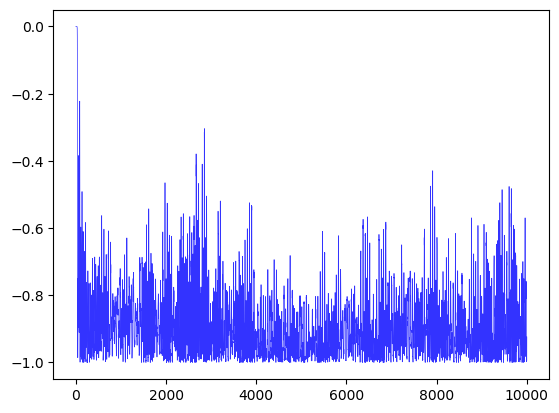

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x17581b690>

In [27]:
E12=Hsys!.(sol12[14,:],sol12[1,:])
plot(sol12.t[:], E12, color="b",linewidth=0.5,alpha=0.8)

In [ ]:
# g=g .* 0. .+ 0.7 /12.
subplot(2, 1, 1)
plot(sol12[14,:],sol12[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol12.t[:], sol12[14,:], color="b",linewidth=0.5,alpha=0.8)

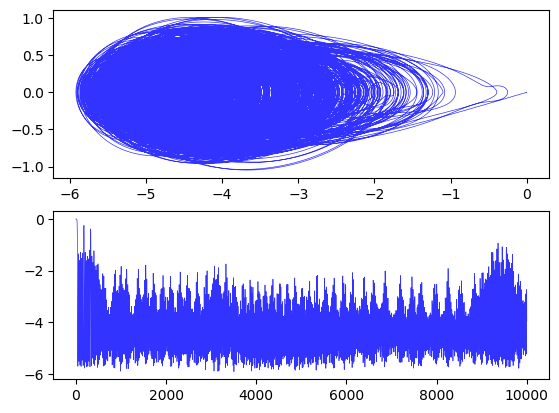

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1f88f2dd0>

In [23]:
#g=g .* 0. .+ 0.5 /12.
subplot(2, 1, 1)
plot(sol12[14,:],sol12[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol12.t[:], sol12[14,:], color="b",linewidth=0.5,alpha=0.8)

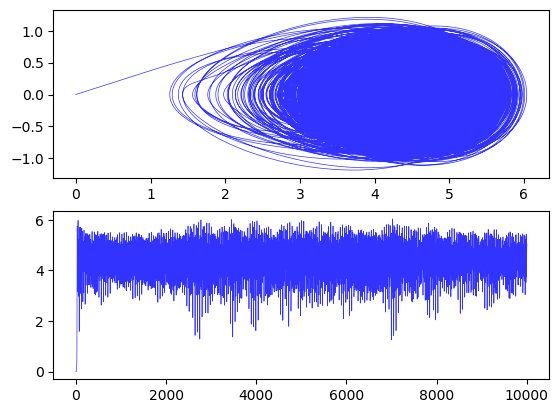

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1f75f2650>

In [20]:
#g=g .* 0. .+ 0.3 /12.
subplot(2, 1, 1)
plot(sol12[14,:],sol12[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol12.t[:], sol12[14,:], color="b",linewidth=0.5,alpha=0.8)

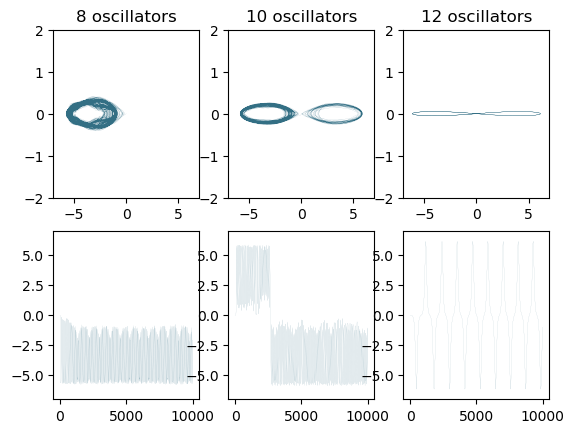

In [18]:
subplot(2, 3, 1)
title("8 oscillators")
plot(sol8[10,:],sol8[1,:],color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
xlim([-7,7])
ylim([-2,2])
subplot(2, 3, 4)
plot(sol8.t[:], sol8[10,:], color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
ylim([-7,7])


subplot(2, 3, 2)
title("10 oscillators")
plot(sol10[12,:],sol10[1,:],color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
xlim([-7,7])
ylim([-2,2])
subplot(2, 3, 5)
plot(sol10.t[:], sol10[12,:], color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
ylim([-7,7])

subplot(2, 3, 3)
title("12 oscillators")
plot(sol12[14,:],sol12[1,:],color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
xlim([-7,7])
ylim([-2,2])
subplot(2, 3, 6)
plot(sol12.t[:], sol12[14,:], color=(0.,75/255,102/255),linewidth=0.05,alpha=0.8)
ylim([-7,7])
savefig("subohm_simetria_freqs_boltz_g_bueno.png")

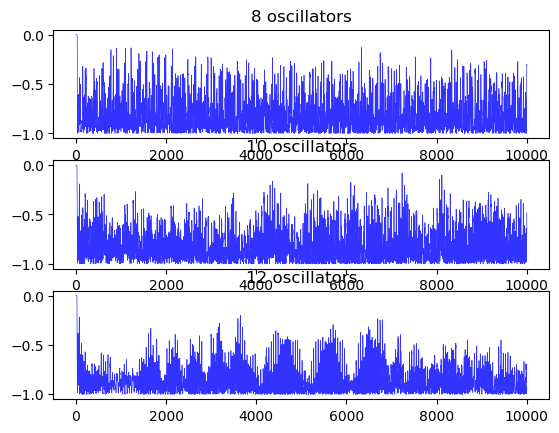

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x196ab46d0>

In [35]:
subplot(3, 1, 1)
title("8 oscillators")
plot(sol8.t[:], E8, color="b",linewidth=0.5,alpha=0.8)
subplot(3, 1, 2)
title("10 oscillators")
plot(sol10.t[:], E10, color="b",linewidth=0.5,alpha=0.8)
subplot(3, 1, 3)
title("12 oscillators")
plot(sol12.t[:], E12, color="b",linewidth=0.5,alpha=0.8)

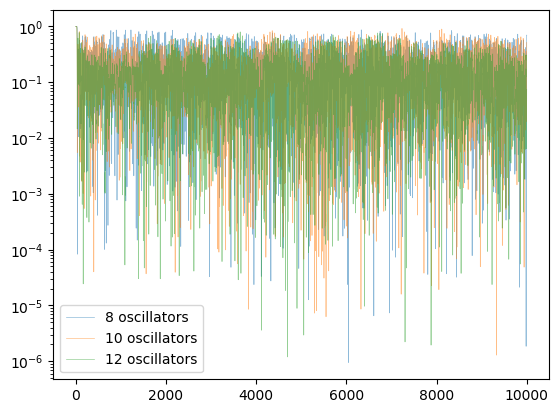

PyObject <matplotlib.legend.Legend object at 0x1b1bb2850>

In [46]:
plot(sol8.t[:], E8 .+1.,linewidth=0.5,alpha=0.5,label="8 oscillators")
plot(sol10.t[:], E10 .+1.,linewidth=0.5,alpha=0.5,label="10 oscillators")
plot(sol12.t[:], E12 .+1.,linewidth=0.5,alpha=0.5,label="12 oscillators")
yscale("log")
legend()

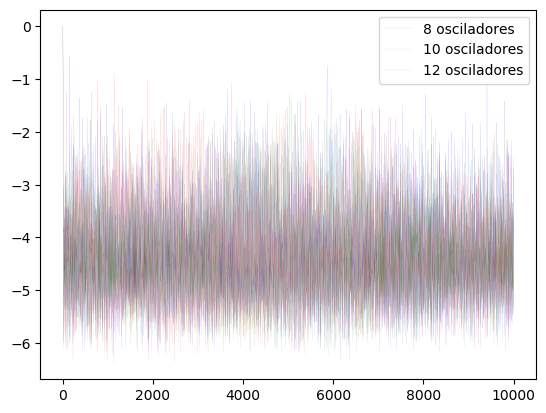

PyObject <matplotlib.legend.Legend object at 0x210ebbf10>

In [75]:
plot(sol8.t[:], sol8[10,:], color="b",linewidth=0.05,alpha=0.8,label="8 osciladores")
plot(sol10.t[:], sol10[12,:], color="r",linewidth=0.05,alpha=0.8,label="10 osciladores")
plot(sol12.t[:], -1*sol12[14,:], color="g",linewidth=0.05,alpha=0.8,label="12 osciladores")
legend()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


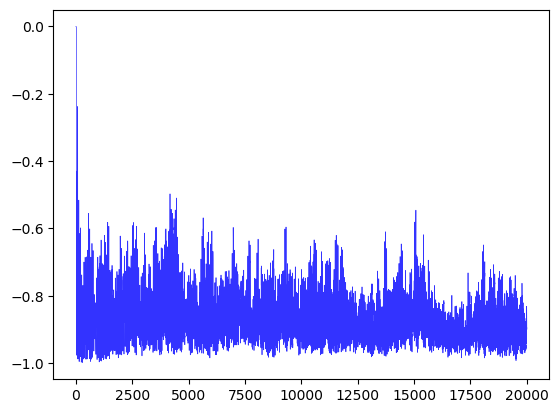

50


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1c929f1d0>

In [43]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(13)

X0=17.    
P0=1.

EE12=0.
sol12=0.

for i in 1:50
println(i)

time=20000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023
w[12]=0.6324555320336759+0.1701
Es[12]=bolz_energy()
g[12]=0.031
w[13]=0.6324555320336759+0.17
Es[13]=Es[12]
g[13]=0.037


g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) -q[1]*g[12]*q[12]+p[12]^2. /(2. *m[12])+m[12]*w[12]^2. *q[12]^2. /2. + q[1]^2. *g[12]^2. /(2. *m[12]*w[12]^2.) -q[1]*g[13]*q[13]+p[13]^2. /(2. *m[13])+m[13]*w[13]^2. *q[13]^2. /2. + q[1]^2. *g[13]^2. /(2. *m[13]*w[13]^2.) 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])
initial_position[12], initial_momentum[12],initial_position[13], initial_momentum[13]=initial_sampling(Es[12],w[12],w[13],m[12])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol12 = solve(prob, CalvoSanz4(), dt=dts)

if i==1
    EE12=Hsys!.(sol12[14,:],sol12[1,:])
    else
        EE12=(EE12+Hsys!.(sol12[14,:],sol12[1,:])) ./2.
    end
end
plot(sol12.t[:], EE12, color="b",linewidth=0.5,alpha=0.8)

# Catorce osciladores

[0.0, 0.48235553203367587, 0.48245553203367586, 0.5323555320336759, 0.5324555320336759, 0.8325555320336759, 0.832455532033676, 0.7325555320336758, 0.7324555320336759, 0.7625555320336759, 0.7624555320336759, 0.8025555320336759, 0.8024555320336759, 0.9325555320336758, 0.9324555320336758]
225.033674 seconds (2.18 G allocations: 76.910 GiB, 14.48% gc time)
1

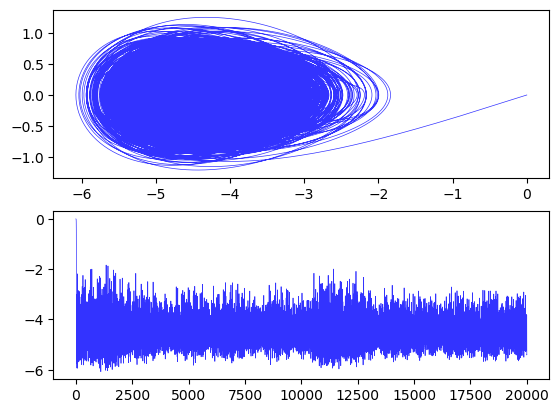

.3224387320567310.028848394627209076
-1.3226035310616933-0.028848394627209076


In [28]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1,0.1,0.1,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(15)

X0=17.    
P0=1.

time=20000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023
w[12]=0.6324555320336759+0.1701
Es[12]=bolz_energy()
g[12]=0.031
w[13]=0.6324555320336759+0.17
Es[13]=Es[12]
g[13]=0.037
w[14]=0.6324555320336759+0.3001
Es[14]=bolz_energy()
g[14]=0.012
w[15]=0.6324555320336759+0.3
Es[15]=Es[14]
g[15]=0.012

g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001
println(w)


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) -q[1]*g[12]*q[12]+p[12]^2. /(2. *m[12])+m[12]*w[12]^2. *q[12]^2. /2. + q[1]^2. *g[12]^2. /(2. *m[12]*w[12]^2.) -q[1]*g[13]*q[13]+p[13]^2. /(2. *m[13])+m[13]*w[13]^2. *q[13]^2. /2. + q[1]^2. *g[13]^2. /(2. *m[13]*w[13]^2.) -q[1]*g[14]*q[14]+p[14]^2. /(2. *m[14])+m[14]*w[14]^2. *q[14]^2. /2. + q[1]^2. *g[14]^2. /(2. *m[14]*w[14]^2.) -q[1]*g[15]*q[15]+p[15]^2. /(2. *m[15])+m[15]*w[15]^2. *q[15]^2. /2. + q[1]^2. *g[15]^2. /(2. *m[15]*w[15]^2.)
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])
initial_position[12], initial_momentum[12],initial_position[13], initial_momentum[13]=initial_sampling(Es[12],w[12],w[13],m[12])
initial_position[14], initial_momentum[14],initial_position[15], initial_momentum[15]=initial_sampling(Es[14],w[14],w[15],m[14])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol14 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol14[16,:],sol14[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol14.t[:], sol14[16,:], color="b",linewidth=0.5,alpha=0.8)
println(initial_position[12], initial_momentum[12])
println(initial_position[13], initial_momentum[13])

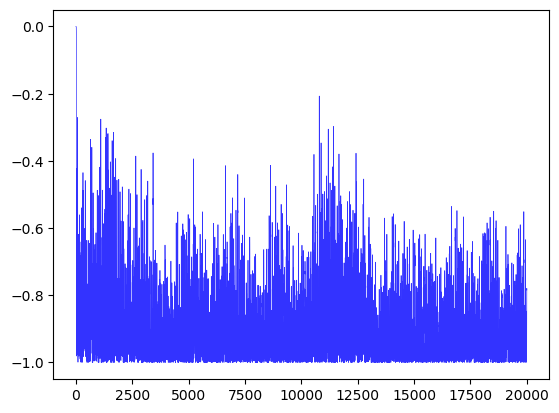

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x175b72410>

In [29]:
E14=Hsys!.(sol14[16,:],sol14[1,:])
plot(sol14.t[:], E14, color="b",linewidth=0.5,alpha=0.8)

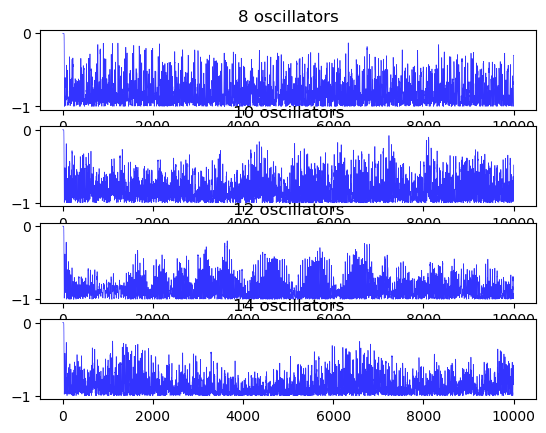

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1969bc110>

In [50]:
subplot(4, 1, 1)
title("8 oscillators")
plot(sol8.t[:], E8, color="b",linewidth=0.5,alpha=0.8)
subplot(4, 1, 2)
title("10 oscillators")
plot(sol10.t[:], E10, color="b",linewidth=0.5,alpha=0.8)
subplot(4, 1, 3)
title("12 oscillators")
plot(sol12.t[:], E12, color="b",linewidth=0.5,alpha=0.8)
subplot(4, 1, 4)
title("14 oscillators")
plot(sol14.t[:], E14, color="b",linewidth=0.5,alpha=0.8)

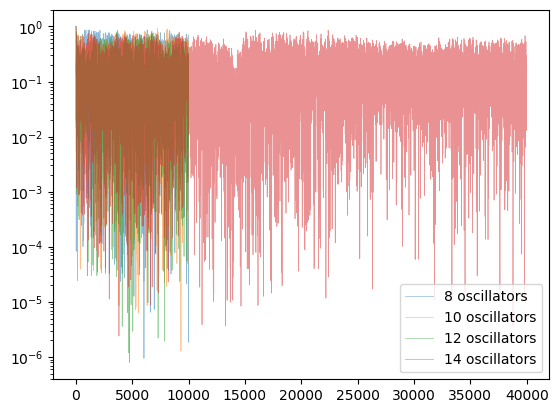

PyObject <matplotlib.legend.Legend object at 0x25e694450>

In [75]:
plot(sol8.t[:], E8 .+1.,linewidth=0.5,alpha=0.5,label="8 oscillators")
plot(sol10.t[:], E10 .+1.,linewidth=0.5,alpha=0.5,label="10 oscillators")
plot(sol12.t[:], E12 .+1.,linewidth=0.5,alpha=0.5,label="12 oscillators")
plot(sol14.t[:], E14 .+1.,linewidth=0.5,alpha=0.5,label="14 oscillators")
yscale("log")
#xlim([5000,40000])
#xscale("log")
legend()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


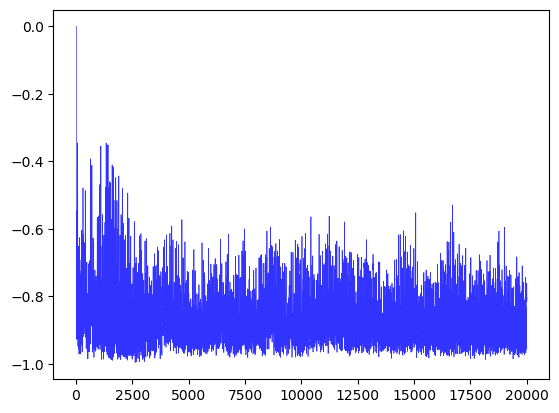

50


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1ca8ca610>

In [44]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.1,0.1,0.1,0.1,0.1,0.1]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
Es=zeros(15)

X0=17.    
P0=1.

E=0.
sol14=0.

for i in 1:50
println(i)

time=20000.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[2]=0.6324555320336759-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759+0.1
Es[9]=Es[8]
g[9]=0.04
w[10]=0.6324555320336759+0.1301
Es[10]=bolz_energy()
g[10]=0.021
w[11]=0.6324555320336759+0.13
Es[11]=Es[10]
g[11]=0.023
w[12]=0.6324555320336759+0.1701
Es[12]=bolz_energy()
g[12]=0.031
w[13]=0.6324555320336759+0.17
Es[13]=Es[12]
g[13]=0.037
w[14]=0.6324555320336759+0.3001
Es[14]=bolz_energy()
g[14]=0.012
w[15]=0.6324555320336759+0.3
Es[15]=Es[14]
g[15]=0.012

g=g .* 0. .+ 0.3 /12.
#w=w .* 0. .+ 1.
#w=(bolz_freq.(w))
#w[3],w[5],w[7],w[9],w[11],w[13]=w[2]+0.0001,w[4]+0.0001,w[6]+0.0001,w[8]+0.0001,w[10]+0.0001,w[12]+0.0001


W=maximum(w)

dts=0.01*2. *pi/W
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) -q[1]*g[10]*q[10]+p[10]^2. /(2. *m[10])+m[10]*w[10]^2. *q[10]^2. /2. + q[1]^2. *g[10]^2. /(2. *m[10]*w[10]^2.) -q[1]*g[11]*q[11]+p[11]^2. /(2. *m[11])+m[11]*w[11]^2. *q[11]^2. /2. + q[1]^2. *g[11]^2. /(2. *m[11]*w[11]^2.) -q[1]*g[12]*q[12]+p[12]^2. /(2. *m[12])+m[12]*w[12]^2. *q[12]^2. /2. + q[1]^2. *g[12]^2. /(2. *m[12]*w[12]^2.) -q[1]*g[13]*q[13]+p[13]^2. /(2. *m[13])+m[13]*w[13]^2. *q[13]^2. /2. + q[1]^2. *g[13]^2. /(2. *m[13]*w[13]^2.) -q[1]*g[14]*q[14]+p[14]^2. /(2. *m[14])+m[14]*w[14]^2. *q[14]^2. /2. + q[1]^2. *g[14]^2. /(2. *m[14]*w[14]^2.) -q[1]*g[15]*q[15]+p[15]^2. /(2. *m[15])+m[15]*w[15]^2. *q[15]^2. /2. + q[1]^2. *g[15]^2. /(2. *m[15]*w[15]^2.)
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)

initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])
initial_position[10], initial_momentum[10],initial_position[11], initial_momentum[11]=initial_sampling(Es[10],w[10],w[11],m[10])
initial_position[12], initial_momentum[12],initial_position[13], initial_momentum[13]=initial_sampling(Es[12],w[12],w[13],m[12])
initial_position[14], initial_momentum[14],initial_position[15], initial_momentum[15]=initial_sampling(Es[14],w[14],w[15],m[14])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
sol14 = solve(prob, CalvoSanz4(), dt=dts)
if i==1
    E=Hsys!.(sol14[16,:],sol14[1,:])
    else
        E=(E+Hsys!.(sol14[16,:],sol14[1,:])) ./2.
    end
end
plot(sol14.t[:], E, color="b",linewidth=0.5,alpha=0.8)

In [87]:
nn=[1,2,3,4]
mm=[5,8,3,2]
nn+mm ./2

4-element Array{Float64,1}:
 3.5
 6.0
 4.5
 5.0

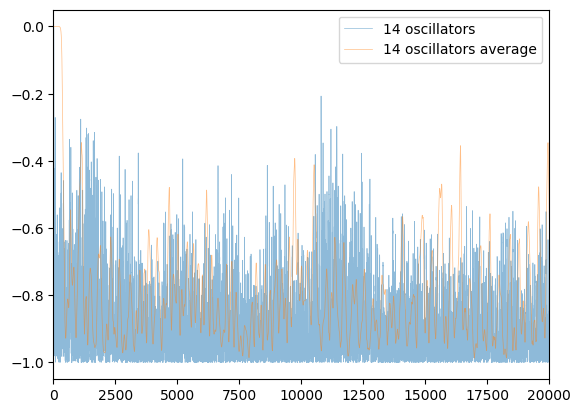

PyObject <matplotlib.legend.Legend object at 0x1ca8b1d90>

In [45]:
#plot(sol8.t[:], E8 ,linewidth=0.5,alpha=0.5,label="8 oscillators")
#plot(sol10.t[:], E10 ,linewidth=0.5,alpha=0.5,label="10 oscillators")
#plot(sol12.t[:], E12 ,linewidth=0.5,alpha=0.5,label="12 oscillators")
plot(sol14.t[:], E14 ,linewidth=0.5,alpha=0.5,label="14 oscillators")
plot(E ,linewidth=0.5,alpha=0.5,label="14 oscillators average")
#yscale("log")
xlim([0,20000])
#xscale("log")
legend()

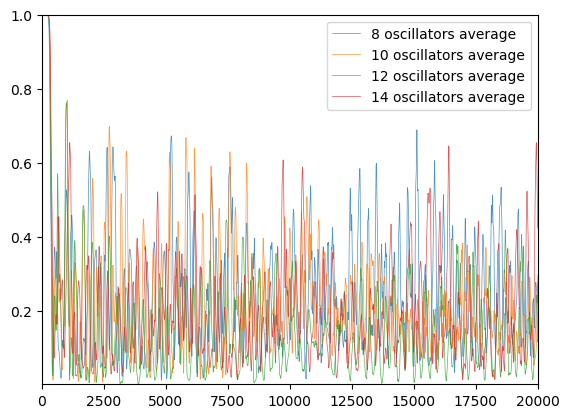

PyObject <matplotlib.legend.Legend object at 0x200c9fd10>

In [54]:
plot(EE8 .+1,linewidth=0.5,alpha=0.8,label="8 oscillators average")
plot(EE10 .+1,linewidth=0.5,alpha=0.8,label="10 oscillators average")
plot(EE12 .+1,linewidth=0.5,alpha=0.8,label="12 oscillators average")
plot(E .+1,linewidth=0.5,alpha=0.8,label="14 oscillators average")
#yscale("log")
xlim([0,20000])
ylim([0.001,1])
#xscale("log")
legend()

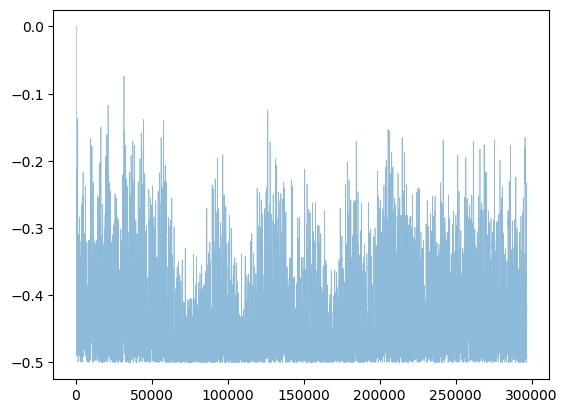

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1758127d0>

In [37]:
plot(E ,linewidth=0.5,alpha=0.5,label="14 oscillators average")

In [2]:
ccc=[1,2,3]
ddd=[2,5,6]
ccc .+ ddd

3-element Array{Int64,1}:
 3
 7
 9

# Anharmonic potential

[1.6076222820191164, 1.5149308391275484, 1.2274840681276342, 1.2771104729127014, 1.8368789601543938, 1.925118075703685, 1.2321094420298617, 1.9838609604240718, 2.0701124506842676, 1.670863465453694, 1.4842627131949697, 1.8200262706898247, 1.6363142998541127, 1.9663901177588066, 1.8358598172917633, 2.0870279187035576, 1.6699560823151618, 1.8486717628891325, 1.1678816420791085, 1.7886300939683342, 1.2557412743137015, 2.026864247135667, 1.3478985425546002, 1.3201096759925612, 1.6334283167481543, 1.802042542846643, 1.6501188721896767, 1.8558527193052348, 1.9500205651432194, 1.5496964631944519, 1.370682307796289, 1.6974368159290831, 1.964044254245835, 1.8313862240906555, 1.9653148923570913, 1.7531311380344488, 1.9619082045282314, 1.7679108544491127, 1.5246100007604508, 1.7305625828257811, 1.1633246918275477, 1.710876206084185, 1.56087987644241, 1.5119856466458315, 1.235964162217729, 1.7874112774882085, 2.0189673939353456, 1.9685112613789502, 1.5070304786676347, 1.9407606705873828, 1.1659663

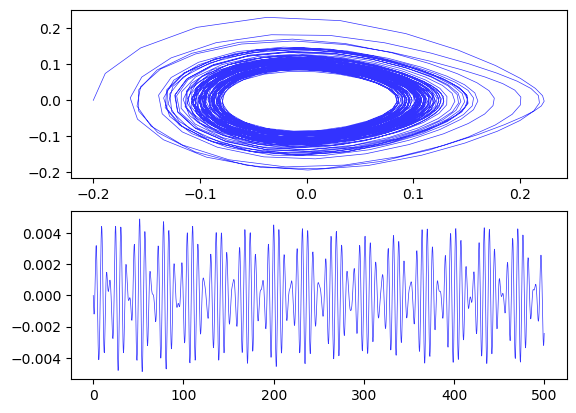

441.045371 seconds (5.73 G allocations: 240.533 GiB, 13.56% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x194ea8690>

In [79]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()+1.1
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]

N=400
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=500.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
println(w)
W=maximum(w)
g=g .* 0. .+ 0.01

dts=0.1*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) +0.0173-(1. /(4. *pi^2. *(sin(2. *pi*(0.1904))+0.25*sin(4. *pi*(0.1904)))))*(sin(2. *pi*(q[1]+0.1904))+0.25*sin(4. *pi*(q[1]+0.1904)))
    for i in 1:N0
        result +=  -q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. + q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=-0.2 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]
 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol8 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol8[402,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol8.t[:], sol8[62,:], color="b",linewidth=0.5,alpha=0.8)

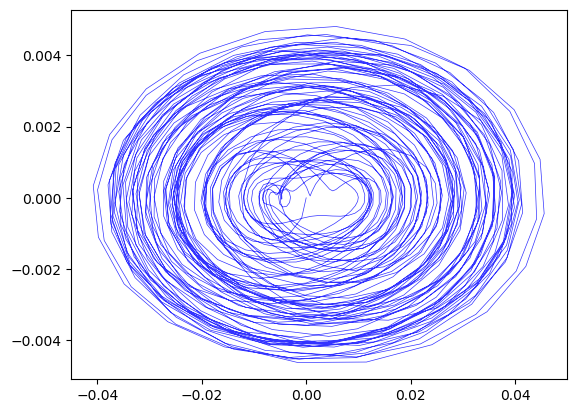

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1897f9d50>

In [82]:
plot(sol8[404,:],sol8[3,:],color="b",linewidth=0.5,alpha=0.8)

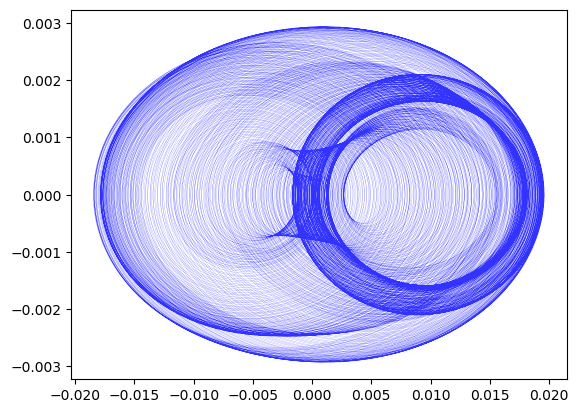

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x195b13910>

In [64]:
plot(sol8[12,:],sol8[2,:],color="b",linewidth=0.1,alpha=0.8)

# harmonic well

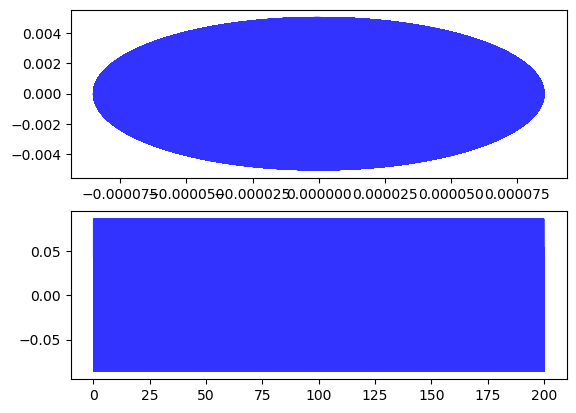

 35.997087 seconds (417.81 M allocations: 17.943 GiB, 28.83% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x25e57cf10>

In [41]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy()
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return 0.6324555320336759*rand(Truncated(Exponential(1), 0.1, 1.))
end

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]

N=8

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(9)

time=200.
#time=1.
tspan=(0., time)
#fig=figure()
m[2:end]=m[2:end] #.*0.1
w[1]=0.6324555320336759
w[2]=0.6324555320336759#-0.1501
Es[2]=bolz_energy()
g[2]=0.005
w[3]=0.6324555320336759#-0.15
Es[3]=Es[2]
g[3]=0.01
w[4]=0.6324555320336759#-0.1001
Es[4]=bolz_energy()
g[4]=0.015
w[5]=0.6324555320336759#-0.1
Es[5]=Es[4]
g[5]=0.02
w[6]=0.6324555320336759#+0.2001
Es[6]=bolz_energy()
g[6]=0.025
w[7]=0.6324555320336759#+0.2
Es[7]=Es[6]
g[7]=0.03
w[8]=0.6324555320336759#+0.1001
Es[8]=bolz_energy()
g[8]=0.035
w[9]=0.6324555320336759#+0.1
Es[9]=Es[8]
g[9]=0.04
w=w .* 0. .+ 60.
W=maximum(w)
g=g .* 0. .+ 0.1#0.3 /8.
dts=0.01*2. *pi/W

#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2.  -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) +0.5* m[1]*w[1]^2. *q[1]^2.
    for i in 1:N0
        result +=  -q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. + q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position[1]=0. #xz0[jj]
initial_momentum[1]=0. #pz1[jj]
initial_position[2], initial_momentum[2],initial_position[3], initial_momentum[3]=initial_sampling(Es[2],w[2],w[3],m[2])
initial_position[4], initial_momentum[4],initial_position[5], initial_momentum[5]=initial_sampling(Es[4],w[4],w[5],m[4])
initial_position[6], initial_momentum[6],initial_position[7], initial_momentum[7]=initial_sampling(Es[6],w[6],w[7],m[6])
initial_position[8], initial_momentum[8],initial_position[9], initial_momentum[9]=initial_sampling(Es[8],w[8],w[9],m[8])

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol8 = solve(prob, CalvoSanz4(), dt=dts)
subplot(2, 1, 1)
plot(sol8[10,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol8.t[:], sol8[11,:], color="b",linewidth=0.5,alpha=0.8)

In [39]:
sol8[11,:]

190987-element Array{Float64,1}:
 0.05045983933387858 
 0.051975824232351135
 0.05329808199532046 
 0.054421684231316096
 0.05534244298861549 
 0.056056926364806775
 0.056562471298363226
 0.056857193494551796
 0.05693999444867959 
 0.05681056554050061 
 0.056469389184522045
 0.05591773703192252 
 0.05515766523078427 
 ⋮                   
 0.030745151424390178
 0.03361252354205796 
 0.036354613223150464
 0.038961200000997696
 0.041422568462763584
 0.04372954446126415 
 0.0458735293093508  
 0.04784653182940748 
 0.049641198138505024
 0.05125083905819595 
 0.05266945504678627 
 0.053814990570817504

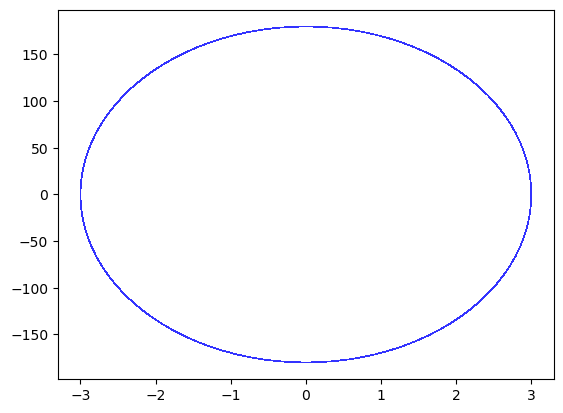

 19.170454 seconds (150.92 M allocations: 4.196 GiB, 28.57% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1baa787d0>

In [34]:
Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2.
m=[1.]
w=[60.]
dts=0.01*2. *pi/w[1]
initial_position=[3.] #xz0[jj]
initial_momentum=[0.4] #pz1[jj]
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol8 = solve(prob, CalvoSanz4(), dt=dts)
plot(sol8[2,:],sol8[1,:],color="b",linewidth=0.5,alpha=0.8)

# Sistema tesis generalizado

In [55]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()*0.4324555320336759+0.63
end
N=0

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]
numeros=[2,4,6,8,10,16,20,26,30,36,40,50,60,80,100]
#numeros=[4]
solu=0
w=0
Es=0
for jj in 1:4
    jj=Int(jj)
for ii in 1:size(numeros)[1]
    println(ii)
    ii=Int(ii)
N=numeros[ii]
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=1000.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
Es=(bolz_energy.(Es))

for i in 1:(N-1)/2
    i=Int(i)
    w[i*2+1]=w[i*2]+0.0001
end

#println(w)
W=maximum(w)
g=g .* 0. .+ 0.3/N

dts=0.01*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4.
    for i in 1:N0
        result +=  -q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. + q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]
if N==2
  initial_position[2], initial_momentum[2],initial_position[2+1], initial_momentum[2+1]=initial_sampling(Es[2],w[2],w[2+1],m[2])      
    end
for i in 1:(N-1)/2
    i=Int(i)
    initial_position[i*2], initial_momentum[i*2],initial_position[i*2+1], initial_momentum[i*2+1]=initial_sampling(Es[i*2],w[i*2],w[i*2+1],m[i*2])
end

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol = solve(prob, CalvoSanz4(), dt=dts)
    solu=sol
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)
title("Particle phase space for N=$N oscillators")
xlim([-6.5,6.5])
ylim([-1.5,1.5])
xlabel("x")
ylabel("p")
plot(sol[N+2,:],sol[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
title("Particle position vs time for N=$N oscillators")
ylim([-6.5,6.5])
xlabel("t")
ylabel("x")
plot(sol.t[:], sol[N+2,:], color="b",linewidth=0.5,alpha=0.8)
fig.tight_layout()
K=Int(N)
savefig("tests_number_oscillators/case$jj/N$N.png")
clf()
#npzwrite("x$N.npy", sol[N+2,:])
#npzwrite("p$N.npy", sol[1,:])
#npzwrite("t$N.npy", sol.t[:])
end
end


1
  3.279202 seconds (14.42 M allocations: 576.232 MiB, 4.87% gc time)
2
  1.531818 seconds (16.85 M allocations: 587.132 MiB, 13.20% gc time)
3
  2.062580 seconds (24.62 M allocations: 981.642 MiB, 13.58% gc time)
4
  2.626935 seconds (34.58 M allocations: 1.518 GiB, 14.23% gc time)
5
  3.228883 seconds (43.47 M allocations: 2.142 GiB, 14.54% gc time)
6
  7.242341 seconds (134.23 M allocations: 5.358 GiB, 14.73% gc time)
7
  9.543280 seconds (169.26 M allocations: 7.582 GiB, 14.45% gc time)
8
 17.031523 seconds (332.98 M allocations: 12.938 GiB, 13.67% gc time)
9
 20.926338 seconds (381.83 M allocations: 16.653 GiB, 14.76% gc time)
10
 31.409764 seconds (589.57 M allocations: 22.714 GiB, 15.46% gc time)
11
 35.610769 seconds (658.17 M allocations: 28.371 GiB, 17.10% gc time)
12
 57.459948 seconds (1.06 G allocations: 45.388 GiB, 17.15% gc time)
13
 79.146415 seconds (1.50 G allocations: 63.797 GiB, 16.14% gc time)
14
118.722367 seconds (2.38 G allocations: 101.157 GiB, 12.10% gc time)

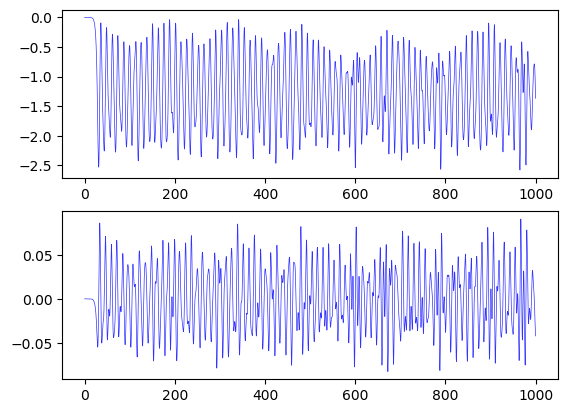

-0.39595593947000407
-4.270984038552178
0.7336034191385258
-2.948587374666121
0.7841616025125212
-0.277926682506956
-2.570003727843256
1.6101001123692078
-1.1542069165629094
-1.4244974891619255
-8.223911909808727
6.997670776789802
-5.071069264305788
2.484017599737844
-1.724306646315251
0.09127735298428603


16

In [26]:
posiciones=zeros(size(solu.t[:])[1])
momentos=zeros(size(solu.t[:])[1])
for i in 1:N
    i=Int(i)
    posiciones=posiciones .+ solu[N+2+i,:]
    momentos=momentos .+ solu[1+i,:]
    println(solu[N+2+i,1000])
end
subplot(2, 1, 1)
plot(solu.t[:],posiciones ./N,color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(solu.t[:], momentos ./N, color="b",linewidth=0.5,alpha=0.8)
N

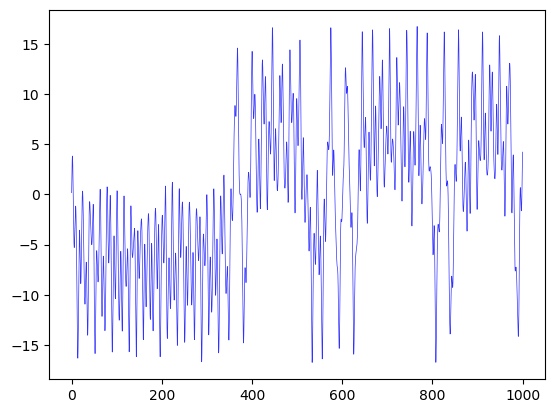

-0.1997539446043329
frequencies  0.7810988922636583  0.9063120084206031
Energies  0.6355081025189372  0.31156074456892724
initial positions  -0.1997539446043329  0.1721565900110318
initial momentums  -0.3561715519681889  0.3561715519681889


In [28]:
plot(solu.t[:],solu[N+2+2,:],color="b",linewidth=0.5,alpha=0.8)
println(solu[N+2+1,1])
println("frequencies  ",w[1*2],"  ",w[1*2+1])
println("Energies  ",Es[1*2],"  ",Es[1*2+1])
println("initial positions  ",initial_position[1*2],"  " ,initial_position[1*2+1] )
println("initial momentums  ",initial_momentum[1*2],"  " ,initial_momentum[1*2+1] )

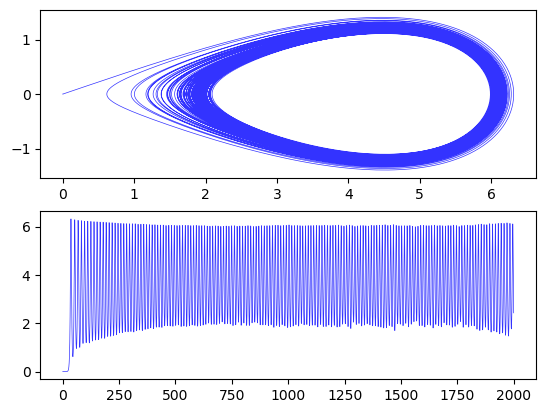

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15bfde650>

In [69]:
subplot(2, 1, 1)
plot(sol400[400+2,:],sol400[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(sol400.t[:], sol400[400+2,:], color="b",linewidth=0.5,alpha=0.8)

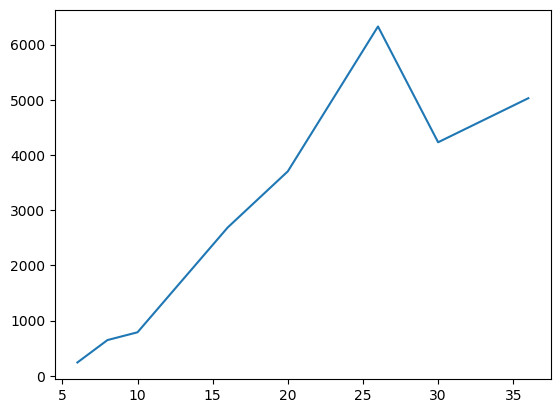

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14a138750>

In [2]:
number=[6,8,10,16,20,26,30,36]
time=[240,646,787,2686,3703,6328,4230,5028]
plot(number,time)


In [98]:
npzwrite("x40.npy", sol40[40+2,:])
npzwrite("p40.npy", sol40[1,:])
npzwrite("t40.npy", sol40.t[:])
npzwrite("x20.npy", sol20[20+2,:])
npzwrite("p20.npy", sol20[1,:])
npzwrite("t20.npy", sol20.t[:])
npzwrite("x14.npy", sol14[14+2,:])
npzwrite("p14.npy", sol14[1,:])
npzwrite("t14.npy", sol14.t[:])
npzwrite("x10.npy", sol10[10+2,:])
npzwrite("p10.npy", sol10[1,:])
npzwrite("t10.npy", sol10.t[:])
npzwrite("x8.npy", sol8[8+2,:])
npzwrite("p8.npy", sol8[1,:])
npzwrite("t8.npy", sol8.t[:])
npzwrite("x30.npy", sol30[30+2,:])
npzwrite("p30.npy", sol30[1,:])
npzwrite("t30.npy", sol30.t[:])

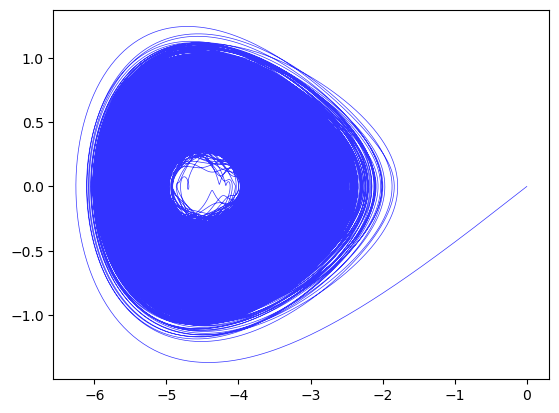

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x265c94a50>

In [93]:
plot(sol40[40+2,:],sol40[1,:],color="b",linewidth=0.5,alpha=0.8)

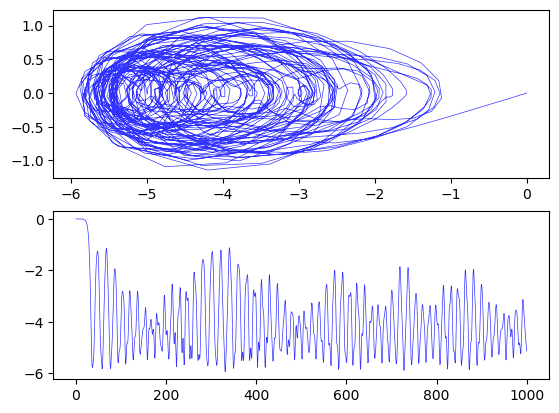

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1534d2190>

In [30]:
subplot(2, 1, 1)
plot(solu[N+2,:],solu[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
plot(solu.t[:], solu[N+2,:], color="b",linewidth=0.5,alpha=0.8)

# Sin la condicion de la suma = 0 para posicion y momento


In [57]:
function initial_sampling(Eb,w1,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()*0.4324555320336759+0.63
end
N=0

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]
numeros=[2,4,6,8,10,16,20,26,30,36,40,50,60,80,100]
#numeros=[4]
solu=0
w=0
Es=0
for jj in 1:4
    jj=Int(jj)
for ii in 1:size(numeros)[1]
    println(ii)
    ii=Int(ii)
N=numeros[ii]
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=1000.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
Es=(bolz_energy.(Es))



#println(w)
W=maximum(w)
g=g .* 0. .+ 0.3/N

dts=0.01*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4.
    for i in 1:N0
        result +=  -q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. + q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]

for i in 1:N
    i=Int(i)
    initial_position[i], initial_momentum[i]=initial_sampling(Es[i],w[i],m[i])
end

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol = solve(prob, CalvoSanz4(), dt=dts)
    solu=sol
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)
title("Particle phase space for N=$N oscillators")
xlim([-6.5,6.5])
ylim([-1.5,1.5])
xlabel("x")
ylabel("p")
plot(sol[N+2,:],sol[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
title("Particle position vs time for N=$N oscillators")
ylim([-6.5,6.5])
xlabel("t")
ylabel("x")
plot(sol.t[:], sol[N+2,:], color="b",linewidth=0.5,alpha=0.8)
fig.tight_layout()
K=Int(N)
savefig("tests_number_oscillators/no0case$jj/N$N.png")
clf()
#npzwrite("x$N.npy", sol[N+2,:])
#npzwrite("p$N.npy", sol[1,:])
#npzwrite("t$N.npy", sol.t[:])
end
end


1
  4.820397 seconds (16.17 M allocations: 630.748 MiB, 14.83% gc time)
2
  2.057234 seconds (19.67 M allocations: 683.574 MiB, 11.65% gc time)
3
  2.741508 seconds (27.60 M allocations: 1.074 GiB, 13.33% gc time)
4
  3.005140 seconds (34.17 M allocations: 1.500 GiB, 13.93% gc time)
5
  3.431470 seconds (45.08 M allocations: 2.222 GiB, 13.45% gc time)
6
  7.361750 seconds (136.08 M allocations: 5.431 GiB, 15.37% gc time)
7
  9.787429 seconds (173.33 M allocations: 7.764 GiB, 14.59% gc time)
8
 17.046743 seconds (333.99 M allocations: 12.978 GiB, 13.81% gc time)
9
 20.091298 seconds (371.02 M allocations: 16.182 GiB, 15.01% gc time)
10
 33.231939 seconds (620.38 M allocations: 23.901 GiB, 16.05% gc time)
11
 37.324269 seconds (687.09 M allocations: 29.617 GiB, 17.22% gc time)
12
 59.888267 seconds (1.07 G allocations: 45.918 GiB, 17.09% gc time)
13
 82.702124 seconds (1.54 G allocations: 65.458 GiB, 17.51% gc time)
14
120.997318 seconds (2.39 G allocations: 101.748 GiB, 13.44% gc time)


sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

 35.505024 seconds (667.44 M allocations: 28.770 GiB, 16.82% gc time)
12
 57.275762 seconds (1.07 G allocations: 45.891 GiB, 16.95% gc time)
13
 83.982229 seconds (1.54 G allocations: 65.738 GiB, 17.32% gc time)
14
122.445049 seconds (2.39 G allocations: 101.742 GiB, 14.93% gc time)
15
189.276543 seconds (3.84 G allocations: 162.684 GiB, 12.71% gc time)
1
  0.625384 seconds (10.37 M allocations: 304.444 MiB, 15.53% gc time)
2
  1.145501 seconds (18.56 M allocations: 633.196 MiB, 17.23% gc time)
3
  1.728156 seconds (27.25 M allocations: 1.052 GiB, 20.38% gc time)
4
  2.005995 seconds (32.59 M allocations: 1.427 GiB, 17.27% gc time)
5
  3.147180 seconds (43.52 M allocations: 2.145 GiB, 31.01% gc time)
6
  7.329966 seconds (134.98 M allocations: 5.387 GiB, 15.84% gc time)
7
  9.287466 seconds (173.22 M allocations: 7.759 GiB, 14.15% gc time)
8
 16.964078 seconds (327.80 M allocations: 12.737 GiB, 14.52% gc time)
9
 20.046332 seconds (383.62 M allocations: 16.732 GiB, 14.55% gc time)
10
 

# Sin el termino extra

### Con la simetria de condiciones iniciales

In [58]:
function initial_sampling(Eb,w1,w2,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    x2=cos(nums[1])*sqrt(Eb/(0.5*mb*w2*w2))
    y2=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1,-x2,-y2
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()*0.4324555320336759+0.63
end
N=0

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]
numeros=[2,4,6,8,10,16,20,26,30,36,40,50,60,80,100]
#numeros=[4]
solu=0
w=0
Es=0
for jj in 1:4
    jj=Int(jj)
for ii in 1:size(numeros)[1]
    println(ii)
    ii=Int(ii)
N=numeros[ii]
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=1000.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
Es=(bolz_energy.(Es))

for i in 1:(N-1)/2
    i=Int(i)
    w[i*2+1]=w[i*2]+0.0001
end

#println(w)
W=maximum(w)
g=g .* 0. .+ 0.3/N

dts=0.01*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4.
    for i in 1:N0
        result +=  +q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. #+ q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]
if N==2
  initial_position[2], initial_momentum[2],initial_position[2+1], initial_momentum[2+1]=initial_sampling(Es[2],w[2],w[2+1],m[2])      
    end
for i in 1:(N-1)/2
    i=Int(i)
    initial_position[i*2], initial_momentum[i*2],initial_position[i*2+1], initial_momentum[i*2+1]=initial_sampling(Es[i*2],w[i*2],w[i*2+1],m[i*2])
end

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol = solve(prob, CalvoSanz4(), dt=dts)
    solu=sol
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)
title("Particle phase space for N=$N oscillators")
#xlim([-6.5,6.5])
#ylim([-1.5,1.5])
xlabel("x")
ylabel("p")
plot(sol[N+2,:],sol[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
title("Particle position vs time for N=$N oscillators")
#ylim([-6.5,6.5])
xlabel("t")
ylabel("x")
plot(sol.t[:], sol[N+2,:], color="b",linewidth=0.5,alpha=0.8)
fig.tight_layout()
K=Int(N)
savefig("tests_number_oscillators/noextracase$jj/N$N.png")
clf()
#npzwrite("x$N.npy", sol[N+2,:])
#npzwrite("p$N.npy", sol[1,:])
#npzwrite("t$N.npy", sol.t[:])
end
end


1
  4.963580 seconds (11.82 M allocations: 526.808 MiB, 14.19% gc time)
2
  1.601733 seconds (12.78 M allocations: 511.901 MiB, 10.97% gc time)
3
  1.955382 seconds (18.21 M allocations: 850.138 MiB, 15.08% gc time)
4
  3.458372 seconds (22.47 M allocations: 1.170 GiB, 44.01% gc time)
5
  2.732764 seconds (29.92 M allocations: 1.769 GiB, 16.12% gc time)
6
  4.888677 seconds (90.01 M allocations: 4.199 GiB, 18.89% gc time)
7
  6.945870 seconds (112.70 M allocations: 5.959 GiB, 19.77% gc time)
8
 11.524964 seconds (217.21 M allocations: 9.803 GiB, 16.56% gc time)
9
 14.697327 seconds (249.86 M allocations: 12.780 GiB, 18.95% gc time)
10
 22.492140 seconds (393.97 M allocations: 17.590 GiB, 15.18% gc time)
11
 23.164145 seconds (441.84 M allocations: 22.267 GiB, 15.61% gc time)
12
 37.362955 seconds (691.43 M allocations: 34.551 GiB, 16.62% gc time)
13
 53.582199 seconds (989.67 M allocations: 49.193 GiB, 15.94% gc time)
14
 81.014529 seconds (1.50 G allocations: 74.394 GiB, 13.84% gc tim

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

 0.732565 seconds (6.78 M allocations: 223.707 MiB, 10.03% gc time)
2
  1.372903 seconds (11.29 M allocations: 444.416 MiB, 41.18% gc time)
3
  1.435248 seconds (15.84 M allocations: 736.554 MiB, 44.09% gc time)
4
  1.247412 seconds (18.23 M allocations: 973.233 MiB, 22.04% gc time)
5
  1.790525 seconds (25.84 M allocations: 1.534 GiB, 22.95% gc time)
6
  5.035501 seconds (89.18 M allocations: 4.160 GiB, 19.27% gc time)
7
  6.533354 seconds (104.69 M allocations: 5.536 GiB, 20.03% gc time)
8
 11.551398 seconds (215.67 M allocations: 9.733 GiB, 19.30% gc time)
9
 13.691703 seconds (251.17 M allocations: 12.847 GiB, 16.34% gc time)
10
 21.548376 seconds (391.52 M allocations: 17.477 GiB, 15.52% gc time)
11
 24.031546 seconds (438.82 M allocations: 22.115 GiB, 17.86% gc time)
12
 36.673651 seconds (667.41 M allocations: 33.351 GiB, 18.88% gc time)
13
 51.874316 seconds (987.84 M allocations: 49.102 GiB, 15.76% gc time)
14
 82.540319 seconds (1.54 G allocations: 76.246 GiB, 16.82% gc time)

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

### Sin la simetria de condiciones iniciales

In [59]:
function initial_sampling(Eb,w1,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()*0.4324555320336759+0.63
end
N=0

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]
numeros=[2,4,6,8,10,16,20,26,30,36,40,50,60,80,100]
#numeros=[4]
solu=0
w=0
Es=0
for jj in 1:4
    jj=Int(jj)
for ii in 1:size(numeros)[1]
    println(ii)
    ii=Int(ii)
N=numeros[ii]
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=1000.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
Es=(bolz_energy.(Es))



#println(w)
W=maximum(w)
g=g .* 0. .+ 0.3/N

dts=0.01*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4.
    for i in 1:N0
        result +=  q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. #+ q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]

for i in 1:N
    i=Int(i)
    initial_position[i], initial_momentum[i]=initial_sampling(Es[i],w[i],m[i])
end

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol = solve(prob, CalvoSanz4(), dt=dts)
    solu=sol
fig, axes = subplots(nrows=2, ncols=1)
subplot(2, 1, 1)
title("Particle phase space for N=$N oscillators")
#xlim([-6.5,6.5])
#ylim([-1.5,1.5])
xlabel("x")
ylabel("p")
plot(sol[N+2,:],sol[1,:],color="b",linewidth=0.5,alpha=0.8)
subplot(2, 1, 2)
title("Particle position vs time for N=$N oscillators")
#ylim([-6.5,6.5])
xlabel("t")
ylabel("x")
plot(sol.t[:], sol[N+2,:], color="b",linewidth=0.5,alpha=0.8)
fig.tight_layout()
K=Int(N)
savefig("tests_number_oscillators/noextrano0case$jj/N$N.png")
clf()
#npzwrite("x$N.npy", sol[N+2,:])
#npzwrite("p$N.npy", sol[1,:])
#npzwrite("t$N.npy", sol.t[:])
end
end


1
  3.616132 seconds (11.80 M allocations: 527.766 MiB, 3.67% gc time)
2
  1.544500 seconds (13.66 M allocations: 546.325 MiB, 13.04% gc time)
3
  1.878574 seconds (19.00 M allocations: 887.065 MiB, 16.37% gc time)
4
  2.411190 seconds (24.56 M allocations: 1.279 GiB, 15.07% gc time)
5
  2.855128 seconds (29.73 M allocations: 1.758 GiB, 15.44% gc time)
6
  5.460933 seconds (89.72 M allocations: 4.186 GiB, 16.82% gc time)
7
  7.241490 seconds (109.21 M allocations: 5.775 GiB, 23.25% gc time)
8
 12.233671 seconds (214.29 M allocations: 9.671 GiB, 16.12% gc time)
9
 13.620077 seconds (249.58 M allocations: 12.765 GiB, 14.52% gc time)
10
 22.117558 seconds (398.49 M allocations: 17.792 GiB, 15.34% gc time)
11
 24.144943 seconds (443.71 M allocations: 22.361 GiB, 16.49% gc time)
12
 35.198775 seconds (680.09 M allocations: 33.985 GiB, 14.13% gc time)
13
 53.942532 seconds (992.96 M allocations: 49.357 GiB, 14.92% gc time)
14
 83.236140 seconds (1.54 G allocations: 76.218 GiB, 15.42% gc time

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

  5.360078 seconds (90.61 M allocations: 4.227 GiB, 17.36% gc time)
7
  6.973762 seconds (111.19 M allocations: 5.879 GiB, 19.55% gc time)
8
 12.198154 seconds (215.09 M allocations: 9.707 GiB, 15.68% gc time)
9
 15.634841 seconds (248.61 M allocations: 12.716 GiB, 21.08% gc time)
10
 21.371684 seconds (400.05 M allocations: 17.857 GiB, 16.52% gc time)
11
 23.660196 seconds (440.90 M allocations: 22.220 GiB, 14.84% gc time)
12
 36.844927 seconds (678.87 M allocations: 33.924 GiB, 16.05% gc time)
13
 56.748342 seconds (990.55 M allocations: 49.237 GiB, 16.80% gc time)
14
 83.267684 seconds (1.54 G allocations: 76.468 GiB, 14.42% gc time)
15
137.418503 seconds (2.48 G allocations: 122.104 GiB, 16.42% gc time)


# Contando veces que salta

### Con el termino extra

In [70]:
function initial_sampling(Eb,w1,mb)
    nums=rand(1)*2*pi
    x1=cos(nums[1])*sqrt(Eb/(0.5*mb*w1*w1))
    y1=sin(nums[1])*sqrt(2*mb*Eb)
    return x1,y1
end

function bolz_energy(a)
    return rand(Truncated(Exponential(1), 0., 10))
end
function bolz_freq(a)
    return rand()*0.4324555320336759+0.63
end
N=0

initial_position = [0.1, 0.,0.,0.,0.,0.,0.,0.,0.]
initial_momentum=[0. ,0.1,0.,0.,0.,0.,0.,0.,0.]
#numeros=[2,4,6,8,10,16,20,26,30,36,40,50,60,80,100]
numeros=[4,6]
promedios=2
solu=0
w=0
Es=0
count=zeros(size(numeros)[1])
for ii in 1:size(numeros)[1]
    println(ii)
    ii=Int(ii)
        
for jj in 1:promedios
    jj=Int(jj)
N=numeros[ii]
initial_position=ones(N+1)
initial_momentum=ones(N+1)

a=0.2
b=0.01

m=[1.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
w=[0.,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
g=[0.,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

X0=17.    
P0=1.

golden=(1+sqrt(big(5)))/2
Es=zeros(N+1)

time=1000.
#time=1.
tspan=(0., time)
#fig=figure()
w=zeros(N+1)
g=zeros(N+1)
E=zeros(N+1)
m=ones(N+1) .*0.1
m[1]=1.
w=w .* 0. .+ 1.
w=(bolz_freq.(w))
Es=(bolz_energy.(Es))



#println(w)
W=maximum(w)
g=g .* 0. .+ 0.3/N

dts=0.01*2. *pi/W
#Hsys(q,p) = p[1]^2. /(2. *m[1]) +m[1]*w[1]^2. *q[1]^2. /2. +0.5* -q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. + q[1]^2. *g[2]^2. /(2. *m[2]*w[2]^2.) -q[1]*g[3]*q[3]+p[3]^2. /(2. *m[3])+m[3]*w[3]^2. *q[3]^2. /2. + q[1]^2. *g[3]^2. /(2. *m[3]*w[3]^2.) -q[1]*g[4]*q[4]+p[4]^2. /(2. *m[4])+m[4]*w[4]^2. *q[4]^2. /2. + q[1]^2. *g[4]^2. /(2. *m[4]*w[4]^2.) -q[1]*g[5]*q[5]+p[5]^2. /(2. *m[5])+m[5]*w[5]^2. *q[5]^2. /2. + q[1]^2. *g[5]^2. /(2. *m[5]*w[5]^2.) -q[1]*g[6]*q[6]+p[6]^2. /(2. *m[6])+m[6]*w[6]^2. *q[6]^2. /2. + q[1]^2. *g[6]^2. /(2. *m[6]*w[6]^2.) -q[1]*g[7]*q[7]+p[7]^2. /(2. *m[7])+m[7]*w[7]^2. *q[7]^2. /2. + q[1]^2. *g[7]^2. /(2. *m[7]*w[7]^2.) -q[1]*g[8]*q[8]+p[8]^2. /(2. *m[8])+m[8]*w[8]^2. *q[8]^2. /2. + q[1]^2. *g[8]^2. /(2. *m[8]*w[8]^2.)-q[1]*g[9]*q[9]+p[9]^2. /(2. *m[9])+m[9]*w[9]^2. *q[9]^2. /2. + q[1]^2. *g[9]^2. /(2. *m[9]*w[9]^2.) 
function Hsys(q,p,N0)
    result=p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4.
    for i in 1:N0
        result +=  -q[1]*g[i+1]*q[i+1]+p[i+1]^2. /(2. *m[2])+m[i+1]*w[i+1]^2. *q[i+1]^2. /2. + q[1]^2. *g[i+1]^2. /(2. *m[i+1]*w[i+1]^2.) 
    end
    return result
end
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p,N), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p,N), p)



initial_position=initial_position .* 0.
initial_momentum=initial_momentum .* 0.
initial_position[1]=0.0 #xz0[jj]
initial_momentum[1]=0.0 #pz1[jj]

for i in 1:N
    i=Int(i)
    initial_position[i], initial_momentum[i]=initial_sampling(Es[i],w[i],m[i])
end

 
prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
@time sol = solve(prob, CalvoSanz4(), dt=dts)
    solu=sol

for j in 1:size(sol[N+2,:])[1]-1
    if sol[N+2,j]<0 && sol[N+2,j+1]>0
        count[ii]=count[ii]+1
    elseif sol[N+2,j]>0 && sol[N+2,j+1]<0
        count[ii]=count[ii]+1
    end
end
end
count=count ./promedios
end
println(count)


1
  9.186265 seconds (23.32 M allocations: 936.961 MiB, 5.93% gc time)
  2.528616 seconds (17.51 M allocations: 597.173 MiB, 17.67% gc time)
2
  6.443415 seconds (26.31 M allocations: 1.024 GiB, 11.25% gc time)
  3.443992 seconds (27.23 M allocations: 1.051 GiB, 13.55% gc time)
[24.75, 26.5]


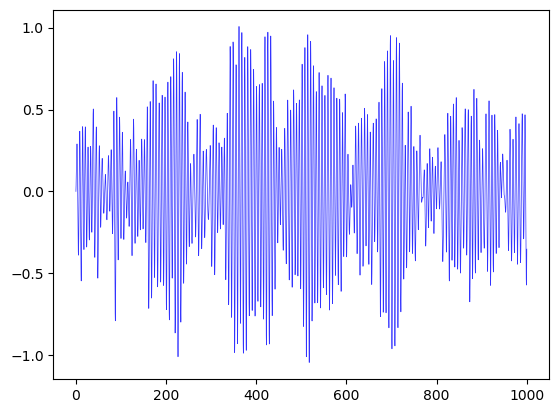

16710


In [68]:
plot(solu.t[:], solu[N+1,:], color="b",linewidth=0.5,alpha=0.8)
println(size(solu[N+1,:])[1])

### Sin el termino extra

In [74]:
ggg=[1,23,4]
ooo=[5,4,6]
hhh=[ggg,ooo]
npzwrite("holas.npy", ggg)